# Timelags
We want to assess whether using a simple dipole geometry versus a geometry derived from the AR magnetogram changes the predictions we make about the heating frequency from 

In [38]:
import os
import sys
#os.environ['MKL_NUM_THREADS'] = '1'
#os.environ['OMP_NUM_THREADS'] = '1'
#os.environ['NUMEXPR_NUM_THREADS'] = '1'

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
import distributed
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from synthesizAR.analysis import DistributedAIACube,AIATimelags
from synthesizAR.visualize import bgry_004_idl_cmap
#sys.path.append('../../scripts/')


%matplotlib inline

In [2]:
cluster = distributed.LocalCluster(n_workers=64,threads_per_worker=1,)
client = distributed.Client(cluster)
client

<Client: scheduler='tcp://127.0.0.1:33887' processes=64 cores=64>

In [3]:
channels = [94,131,171,193,211,335]

In [4]:
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

In [5]:
timelag_bounds = u.Quantity([-6,6],u.hour)

In [11]:
correlation_threshold = 0.1

## Simple Dipole

In [6]:
path_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/{}_frequency/SDO_AIA/{}/map_t{:06d}.fits'

In [7]:
high = AIATimelags(*[DistributedAIACube.from_files([path_format.format('high',c,i) for i in range(500,2500)]) for c in channels])

In [8]:
intermediate = AIATimelags(*[DistributedAIACube.from_files([path_format.format('intermediate',c,i) for i in range(500,2500)]) for c in channels])

In [9]:
low = AIATimelags(*[DistributedAIACube.from_files([path_format.format('low',c,i) for i in range(500,2500)]) for c in channels])

In [10]:
simple_timelags = {'high': {}, 'intermediate': {}, 'low': {}}
simple_correlations = {'high': {}, 'intermediate': {}, 'low': {}}
for ca,cb in channel_pairs:
    lab = f'{ca}_{cb}'
    # High
    tl = high.make_timelag_map(ca, cb, timelag_bounds=timelag_bounds, )# chunks=(20,20))
    cor = high.make_correlation_map(ca, cb, timelag_bounds=timelag_bounds, )# chunks=(20,20))
    simple_timelags['high'][lab] = tl
    simple_correlations['high'][lab] = cor
    # Intermediate
    tl,cor = intermediate.make_timelag_map(ca, cb, timelag_bounds=timelag_bounds, return_correlation_map=True,)# chunks=(20,20))
    simple_timelags['intermediate'][lab] = tl
    simple_correlations['intermediate'][lab] = cor
    ## Low
    tl,cor = low.make_timelag_map(ca, cb, timelag_bounds=timelag_bounds, return_correlation_map=True,)# chunks=(20,20))
    simple_timelags['low'][lab] = tl
    simple_correlations['low'][lab] = cor

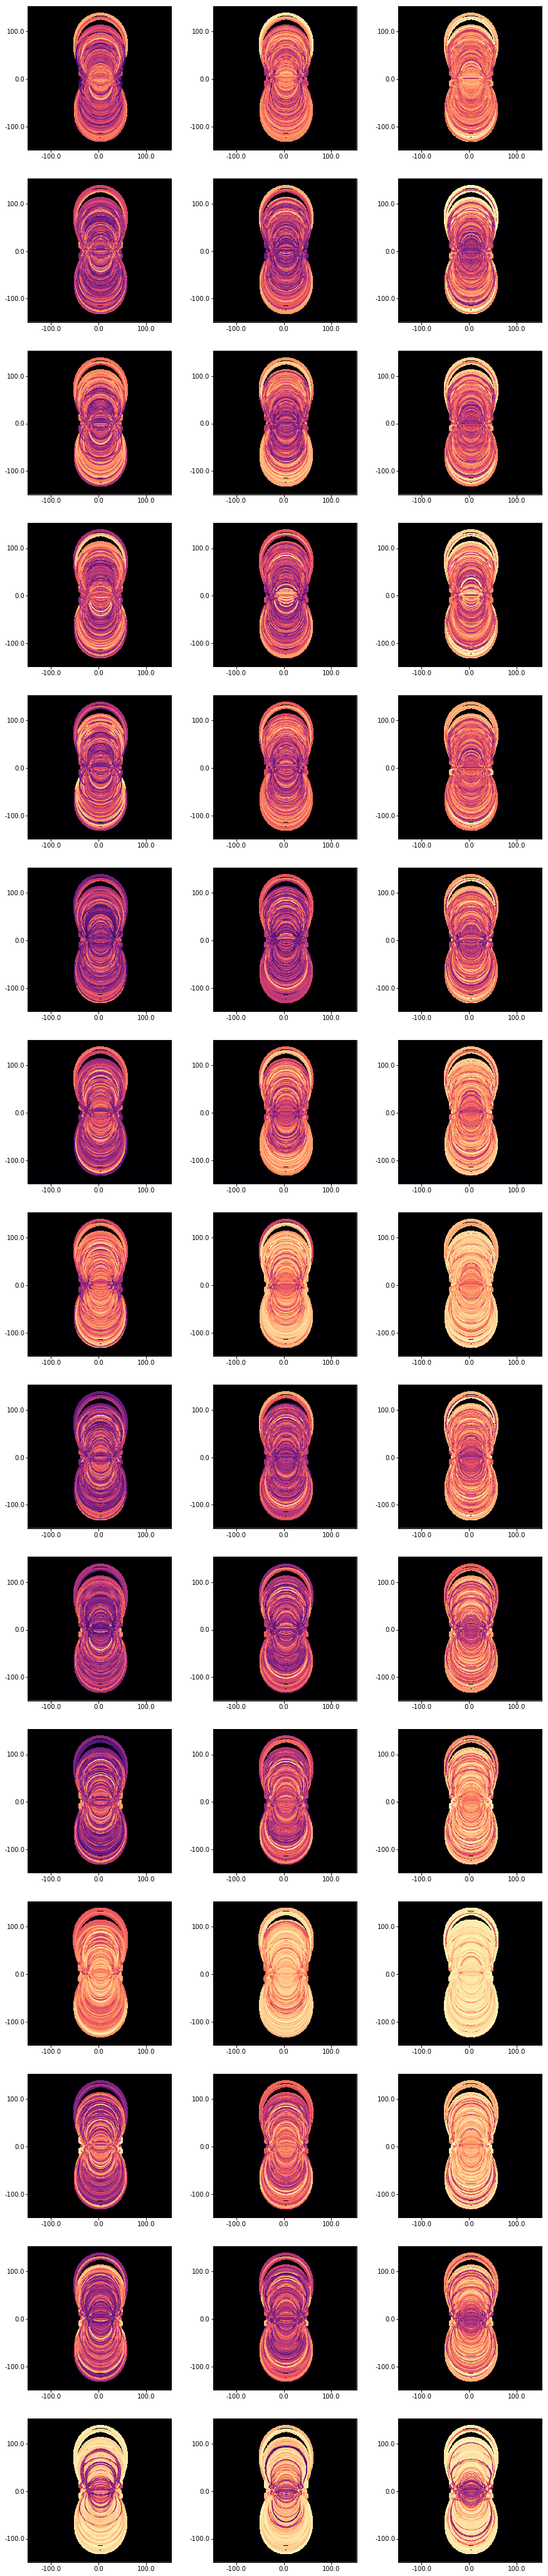

In [13]:
fig = plt.figure(figsize=(15,75))
opts = {'annotate': False, 'title': False, 'cmap': 'magma', 'vmin': 0, 'vmax': 1}
for i,cp in enumerate(channel_pairs):
    m = simple_correlations['high']['{}_{}'.format(*cp)]
    ax = fig.add_subplot(15,3,3*i+1,projection=m)
    m.plot(axes=ax, **opts)
    ax.grid(alpha=0)
    m = simple_correlations['intermediate']['{}_{}'.format(*cp)]
    ax = fig.add_subplot(15,3,3*i+2,projection=m)
    m.plot(axes=ax, **opts)
    ax.grid(alpha=0)
    m = simple_correlations['low']['{}_{}'.format(*cp)]
    ax = fig.add_subplot(15,3,3*i+3,projection=m)
    m.plot(axes=ax, **opts)
    ax.grid(alpha=0)

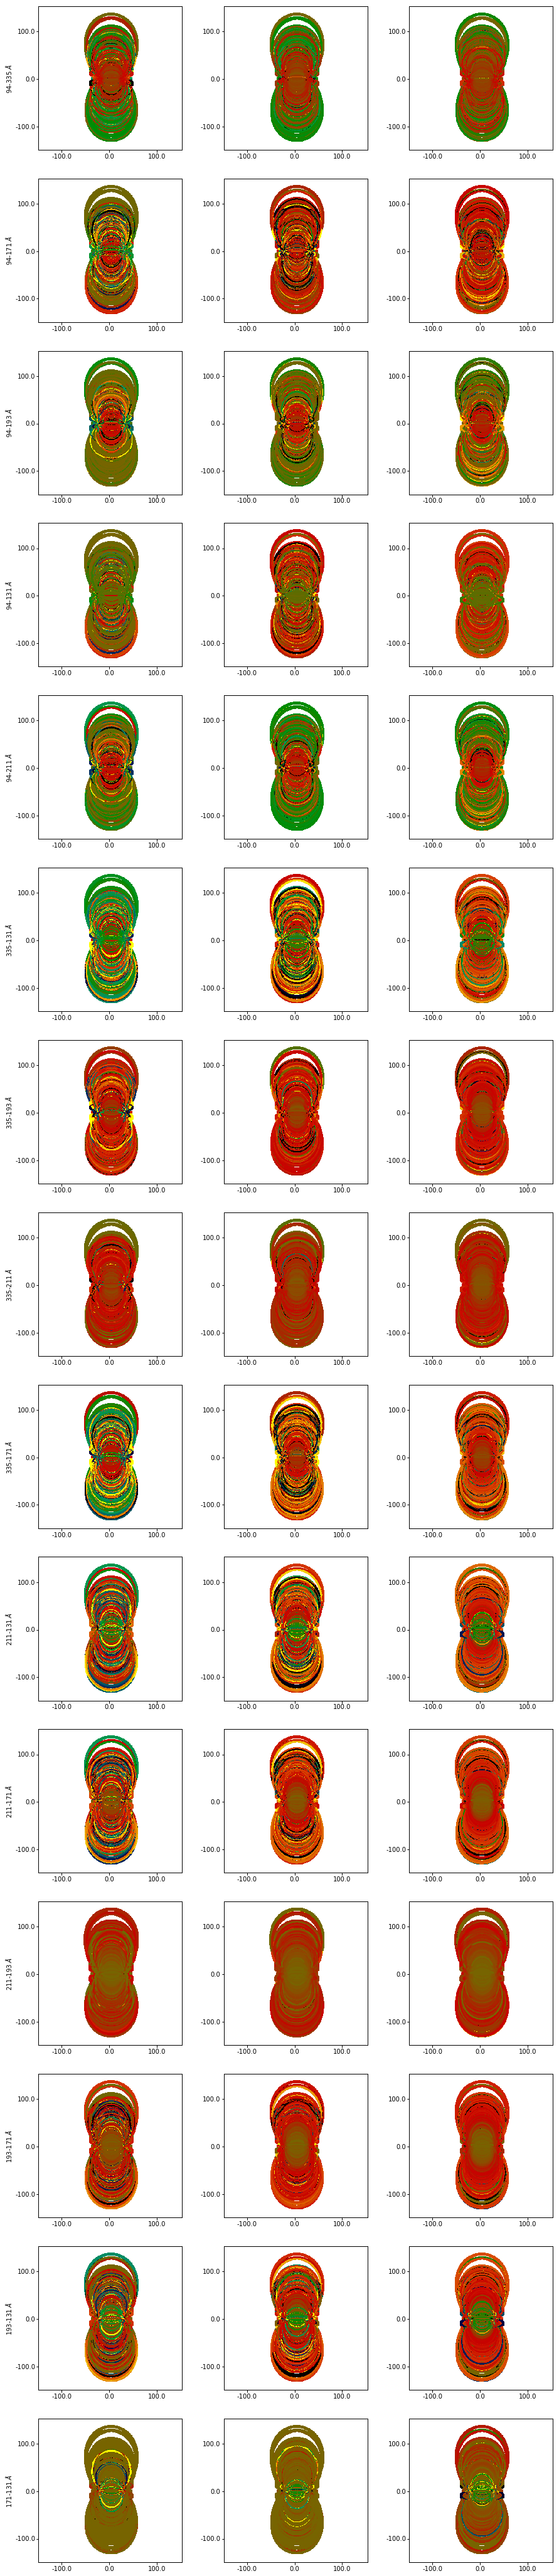

In [14]:
fig = plt.figure(figsize=(15,75))
opts = {'annotate': False, 'title': False, 'vmin': (-2*u.hour).to(u.s).value, 'vmax': (2*u.hour).to(u.s).value, 'cmap': bgry_004_idl_cmap}
for i,cp in enumerate(channel_pairs):
    # High
    m = simple_timelags['high']['{}_{}'.format(*cp)]
    mc = simple_correlations['high']['{}_{}'.format(*cp)]
    m = sunpy.map.Map(m.data, m.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
    ax = fig.add_subplot(15,3,3*i+1,projection=m)
    m.plot(axes=ax, **opts)
    ax.grid(alpha=0)
    ax.coords[1].set_axislabel('{}-{} $\AA$'.format(*cp))
    # Intermediate
    m = simple_timelags['intermediate']['{}_{}'.format(*cp)]
    mc = simple_correlations['intermediate']['{}_{}'.format(*cp)]
    m = sunpy.map.Map(m.data, m.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
    ax = fig.add_subplot(15,3,3*i+2,projection=m)
    m.plot(axes=ax, **opts)
    ax.grid(alpha=0)
    # Low
    m = simple_timelags['low']['{}_{}'.format(*cp)]
    mc = simple_correlations['low']['{}_{}'.format(*cp)]
    m = sunpy.map.Map(m.data, m.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
    ax = fig.add_subplot(15,3,3*i+3,projection=m)
    m.plot(axes=ax, **opts)
    ax.grid(alpha=0)

In [134]:
for h in ['high','intermediate','low']:
    for cp in channel_pairs:
        simple_correlations[h]['{}_{}'.format(*cp)].save(f'/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/{h}_frequency/timelags/correlation_{cp[0]}_{cp[1]}.fits')
        simple_timelags[h]['{}_{}'.format(*cp)].save(f'/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/{h}_frequency/timelags/timelag_{cp[0]}_{cp[1]}.fits')

## Full Geometry

In [43]:
path_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{}_frequency/nei/SDO_AIA/{}/map_t{:06d}.fits'

In [44]:
high = AIATimelags(*[DistributedAIACube.from_files([path_format.format('high',c,i) for i in range(500,2500)]) for c in channels])

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


In [45]:
intermediate = AIATimelags(*[DistributedAIACube.from_files([path_format.format('intermediate',c,i) for i in range(500,2500)]) for c in channels])

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


In [46]:
low = AIATimelags(*[DistributedAIACube.from_files([path_format.format('low',c,i) for i in range(500,2500)]) for c in channels])

In [47]:
ar_timelags = {'high': {}, 'intermediate': {}, 'low': {}}
ar_correlations = {'high': {}, 'intermediate': {}, 'low': {}}
for ca,cb in channel_pairs:
    lab = f'{ca}_{cb}'
    # High
    ar_timelags['high'][lab] = high.make_timelag_map(ca, cb, timelag_bounds=timelag_bounds,)
    ar_correlations['high'][lab] = high.make_correlation_map(ca, cb, timelag_bounds=timelag_bounds,)
    # Intermediate
    ar_timelags['intermediate'][lab] = intermediate.make_timelag_map(ca, cb, timelag_bounds=timelag_bounds,)
    ar_correlations['intermediate'][lab] = intermediate.make_correlation_map(ca, cb, timelag_bounds=timelag_bounds,)
    ## Low
    ar_timelags['low'][lab] = low.make_timelag_map(ca, cb, timelag_bounds=timelag_bounds,)
    ar_correlations['low'][lab] = low.make_correlation_map(ca, cb, timelag_bounds=timelag_bounds,)

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

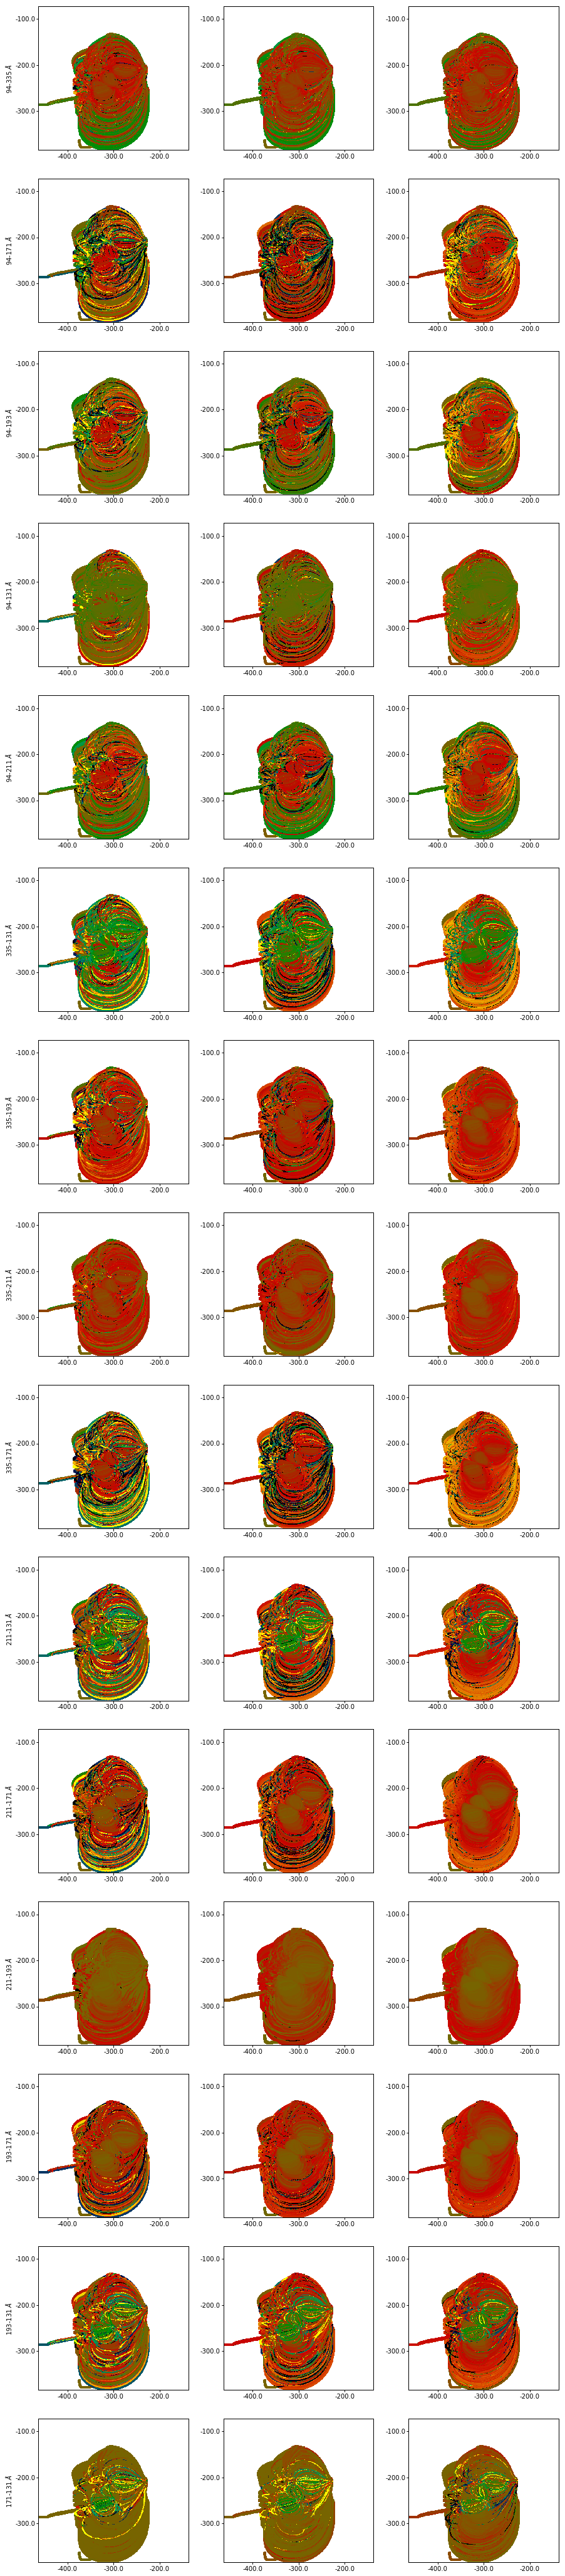

In [119]:
fig = plt.figure(figsize=(15,75))
opts = {'annotate': False, 'title': False, 'vmin': (-2*u.hour).to(u.s).value, 'vmax': (2*u.hour).to(u.s).value, 'cmap': bgry_004_idl_cmap}
for i,cp in enumerate(channel_pairs):
    # High
    m = ar_timelags['high']['{}_{}'.format(*cp)]
    mc = ar_correlations['high']['{}_{}'.format(*cp)]
    m = sunpy.map.Map(m.data, m.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
    ax = fig.add_subplot(15,3,3*i+1,projection=m)
    m.plot(axes=ax, **opts)
    ax.grid(alpha=0)
    ax.coords[1].set_axislabel('{}-{} $\AA$'.format(*cp))
    # Intermediate
    m = ar_timelags['intermediate']['{}_{}'.format(*cp)]
    mc = ar_correlations['intermediate']['{}_{}'.format(*cp)]
    m = sunpy.map.Map(m.data, m.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
    ax = fig.add_subplot(15,3,3*i+2,projection=m)
    m.plot(axes=ax, **opts)
    ax.grid(alpha=0)
    # Low
    m = ar_timelags['low']['{}_{}'.format(*cp)]
    mc = ar_correlations['low']['{}_{}'.format(*cp)]
    m = sunpy.map.Map(m.data, m.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
    ax = fig.add_subplot(15,3,3*i+3,projection=m)
    m.plot(axes=ax, **opts)
    ax.grid(alpha=0)

### Histograms

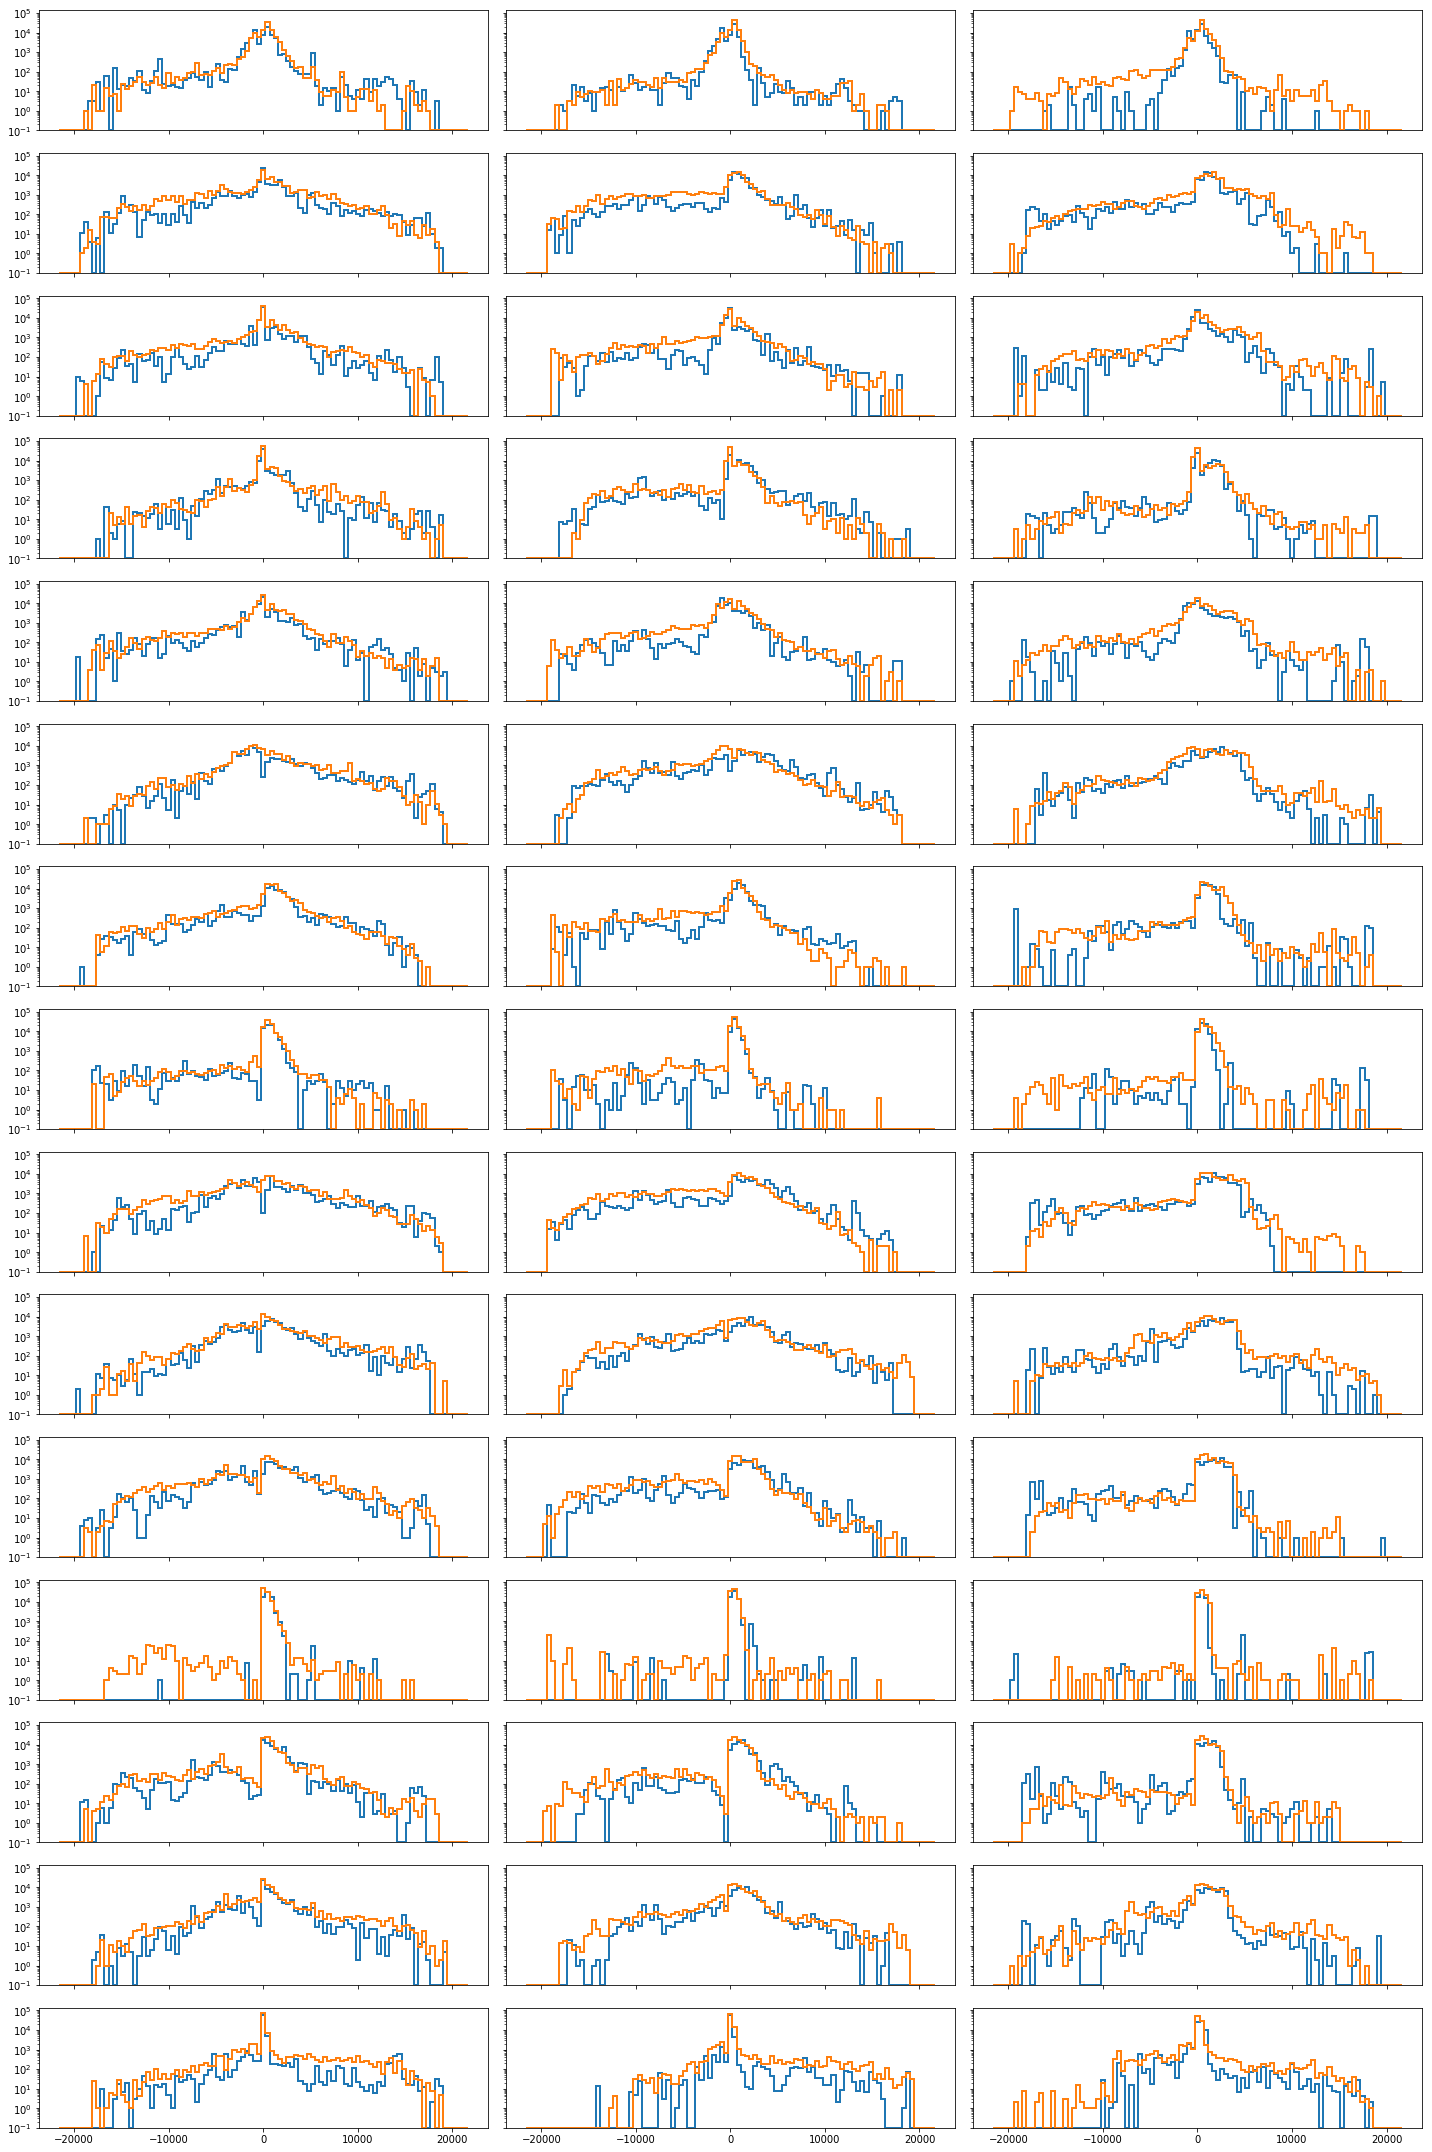

In [133]:
bins = np.linspace((-6*u.h).to(u.s).value, (6*u.h).to(u.s).value,100)
opts = {'histtype':'step', 'bins':bins, 'lw':2, 'log':True}
fig,axes = plt.subplots(15,3,figsize=(20,30),sharex=True,sharey=True)
for i,cp in enumerate(channel_pairs):
    for j,h in enumerate(['high', 'intermediate', 'low']):
        ax = axes[i,j]
        # Simple
        m = simple_timelags[h]['{}_{}'.format(*cp)]
        mc = simple_correlations[h]['{}_{}'.format(*cp)]
        m = sunpy.map.Map(m.data, m.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
        ax.hist(m.data[~m.mask].flatten(),**opts, color='C0', label='Simple')
        # AR
        m = ar_timelags[h]['{}_{}'.format(*cp)]
        mc = ar_correlations[h]['{}_{}'.format(*cp)]
        m = sunpy.map.Map(m.data, m.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
        ax.hist(m.data[~m.mask].flatten(),**opts, color='C1', label='NOAA 1158')
plt.tight_layout()

## Observations

In [15]:
path_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_*_{}_cutout.fits'

In [16]:
obs = AIATimelags(*[DistributedAIACube.from_files(path_format.format(c)) for c in channels])

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/synthesizAR/analysis/aia.py:203: UserWarning: Time dimensions are not all equal length
  warnings.warn('Time dimensions are not all equal length')


In [17]:
obs_timelags,obs_correlations = {},{}
for cp in channel_pairs:
    obs_timelags['{}_{}'.format(*cp)] = obs.make_timelag_map(*cp, timelag_bounds=timelag_bounds,)
    obs_correlations['{}_{}'.format(*cp)] = obs.make_correlation_map(*cp, timelag_bounds=timelag_bounds)

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

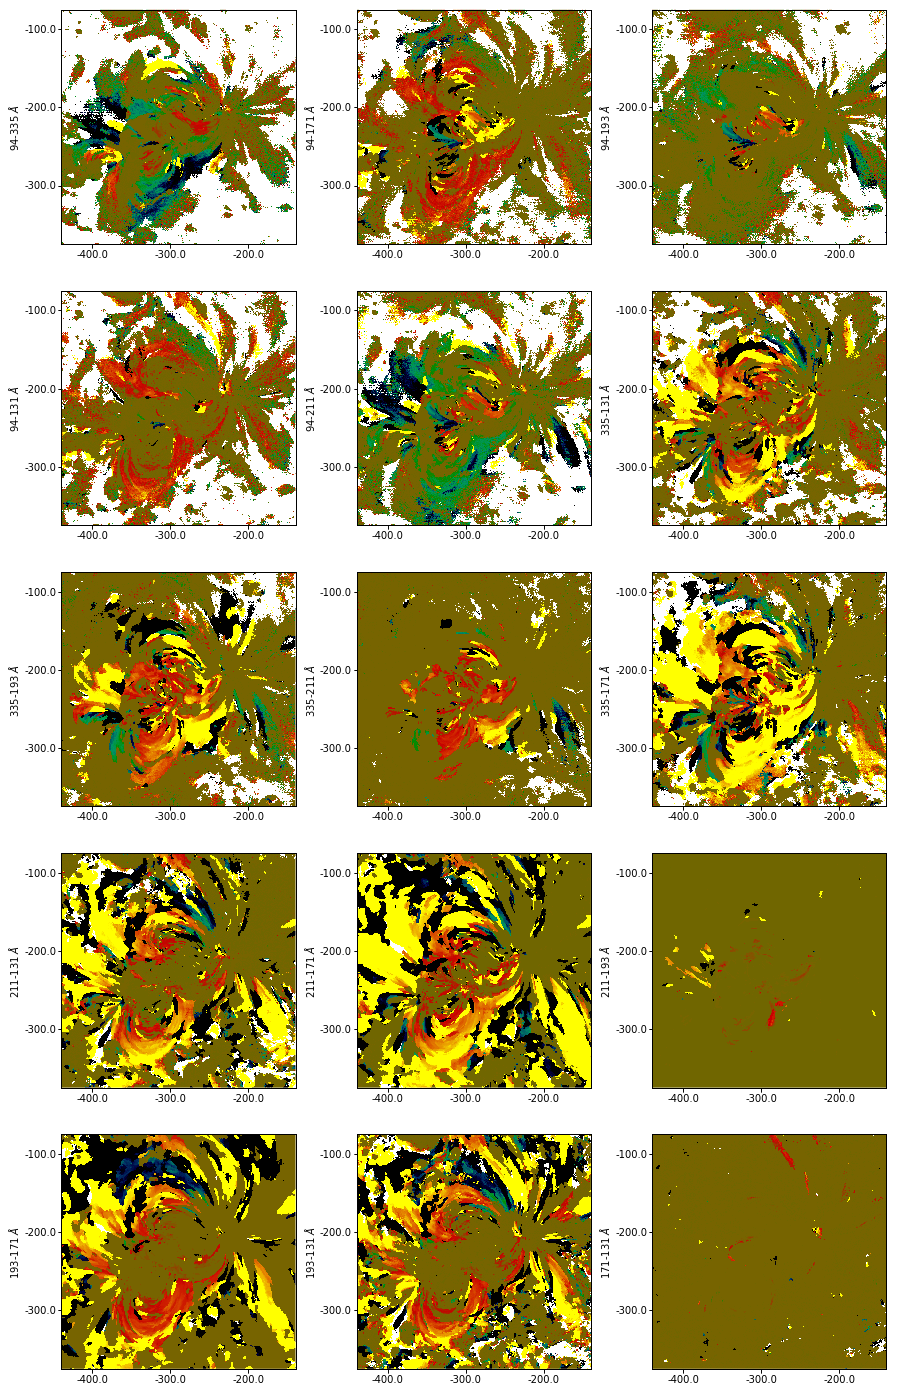

In [50]:
fig = plt.figure(figsize=(15,25))
opts = {'annotate': False, 'title': False, 'vmin': (-2*u.hour).to(u.s).value, 'vmax': (2*u.hour).to(u.s).value, 'cmap': bgry_004_idl_cmap}
for i,cp in enumerate(channel_pairs):
    m = obs_timelags['{}_{}'.format(*cp)]
    mc = obs_correlations['{}_{}'.format(*cp)]
    m = sunpy.map.Map(m.data, m.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
    ax = fig.add_subplot(5,3,i+1,projection=m)
    m.plot(axes=ax, **opts)
    ax.grid(alpha=0)
    ax.coords[1].set_axislabel('{}-{} $\AA$'.format(*cp))

## Classification

First, prep the observational data

In [21]:
# Find the indices where all channel pairs have an acceptable correlation
acceptable_correlation = np.all(np.stack([obs_correlations['{}_{}'.format(*p)].data
                                          for p in channel_pairs], axis=2) > correlation_threshold, axis=2)
i_accept_obs = np.where(acceptable_correlation)
# Stack maps
X_observation = None
for p in channel_pairs:
    # Read in timelags and correlations
    tmp_tl = obs_timelags['{}_{}'.format(*p)].data
    # Only keep those timelags with sufficiently high correlations
    tmp_tl = tmp_tl[i_accept_obs].flatten()
    # Stack along columns for different channel pairs
    X_observation = tmp_tl.copy()[:,np.newaxis] if X_observation is None else np.hstack([X_observation, tmp_tl[:, np.newaxis]])
# Scale data
X_observation = scale(X_observation, axis=0, with_mean=True, with_std=True)

### Simple Dipole Geometry

Next, perform the classification using the simple dipole data

In [60]:
X = None
Y = None
titles = ['High','Intermediate','Low']
for i,f in enumerate(titles):
    X_tmp = None
    # Find the indices where all channel pairs have an acceptable correlation
    acceptable = np.all(np.stack([simple_correlations[f.lower()]['{}_{}'.format(*p)].data for p in channel_pairs], axis=2) 
                        > correlation_threshold,axis=2)
    i_accept = np.where(acceptable)
    for p in channel_pairs:
        # Read in timelags and correlations
        tmp_tl = simple_timelags[f.lower()]['{}_{}'.format(*p)].data
        # Only keep those timelags with sufficiently high correlations
        tmp_tl = tmp_tl[i_accept].flatten()
        # Stack along columns for different channel pairs
        X_tmp = tmp_tl.copy()[:,np.newaxis] if X_tmp is None else np.hstack([X_tmp, tmp_tl[:, np.newaxis]])
    # Stack along rows for different frequencies
    X = X_tmp.copy() if X is None else np.vstack([X, X_tmp])
    Y_tmp = np.array(X_tmp.shape[0]*[f])
    Y = Y_tmp.copy() if Y is None else np.concatenate([Y, Y_tmp])
# Numerically encode frequency
le = LabelEncoder()
le.fit(titles)
Y_encoded = le.transform(Y)
# Scale data
X_scaled = scale(X, axis=0, with_mean=True, with_std=True,)
# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_encoded, test_size=0.33)

In [91]:
clf = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=50,bootstrap=True,)

In [92]:
clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [93]:
clf.score(X_test,Y_test)

0.993163964326234

In [94]:
Y_observation = clf.predict(X_observation)

In [95]:
Y_observation_prob = clf.predict_proba(X_observation)

In [96]:
probability_maps = {}
for i,f in enumerate(titles):
    tmp = np.nan*obs_timelags['{}_{}'.format(*channel_pairs[0])].data
    tmp[i_accept_obs] = Y_observation_prob[:,i]
    probability_maps[f] = sunpy.map.Map(tmp, obs_timelags['{}_{}'.format(*channel_pairs[0])].meta)

In [97]:
tmp = np.nan*obs_timelags['{}_{}'.format(*channel_pairs[0])].data
tmp[i_accept_obs] = Y_observation
frequency_map = sunpy.map.Map(tmp, obs_timelags['{}_{}'.format(*channel_pairs[0])].meta)

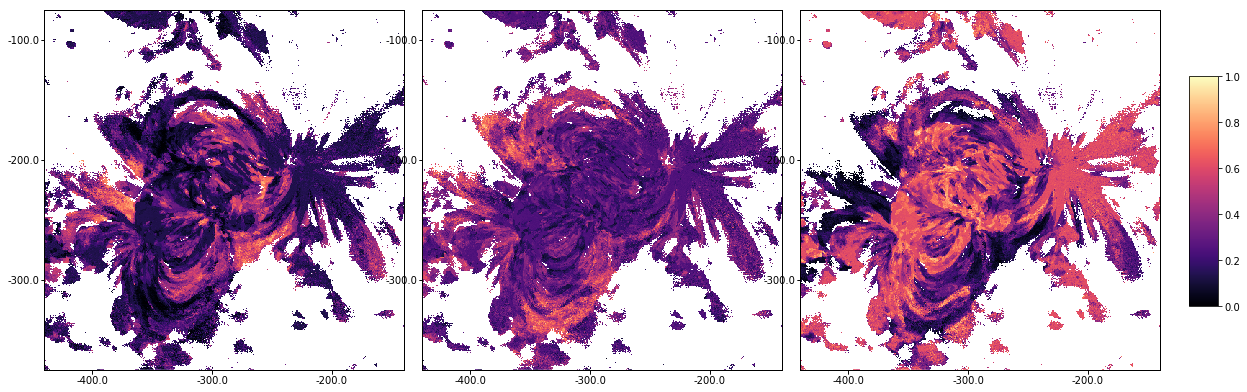

In [98]:
fig = plt.figure(figsize=(20,8))
cax = fig.add_axes((0.92,0.3,0.02,0.4))
p_args = {'annotate':False,'vmin':0,'vmax':1,'cmap':'magma'}
# Probability maps
## High
ax = fig.add_subplot(1,3,1,projection=probability_maps['High'])
probability_maps['High'].plot(axes=ax,**p_args,title='High')
ax.grid(alpha=0)
## Intermediate
ax = fig.add_subplot(1,3,2,projection=probability_maps['Intermediate'])
probability_maps['Intermediate'].plot(axes=ax,**p_args,title='Intermediate')
ax.grid(alpha=0)
## Low
ax = fig.add_subplot(1,3,3,projection=probability_maps['Low'])
im = probability_maps['Low'].plot(axes=ax,**p_args,title='Low')
ax.grid(alpha=0)
## Colorbar and adjustments
cbar = fig.colorbar(im, cax=cax,orientation='vertical')
plt.subplots_adjust(hspace=0,wspace=0.05)

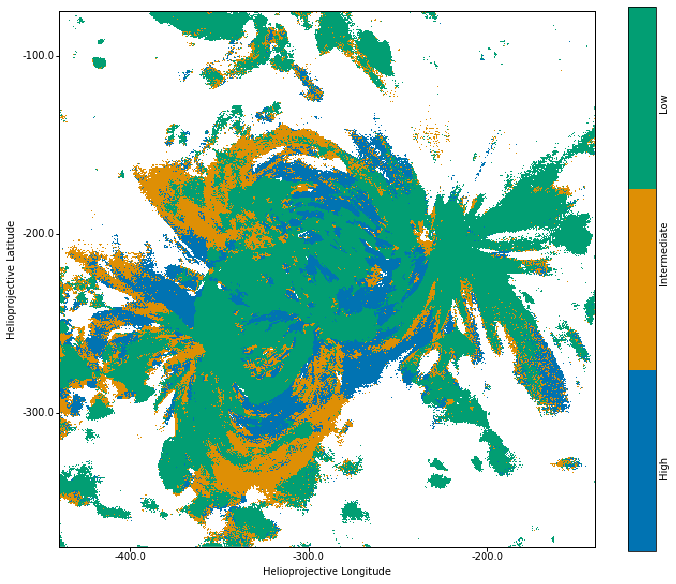

In [99]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=frequency_map)
im = frequency_map.plot(
    axes=ax,title=False,
    cmap=matplotlib.colors.ListedColormap(seaborn.color_palette(palette='colorblind',n_colors=3,),N=3),
    vmin=-0.5,vmax=2.5)
lon,lat = ax.coords[0],ax.coords[1]
lon.set_axislabel('Helioprojective Longitude',fontsize=plt.rcParams['axes.labelsize'])
lat.set_axislabel('Helioprojective Latitude',fontsize=plt.rcParams['axes.labelsize'])
lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'])
cbar = fig.colorbar(im, ax=ax,)# ticks=[0,1,2], format=plt.FuncFormatter(lambda val, loc: ['high','intermediate','low'][val]),)
cbar.set_ticks([0,1.3,2])
cbar.ax.set_yticklabels(['High','Intermediate','Low'],rotation=90)
cbar.ax.tick_params(axis='y',which='both',length=0)
ax.grid(alpha=0)

### Active Region Geometry

Now, perform the classification using the "realistic" AR data.

In [100]:
X = None
Y = None
titles = ['High','Intermediate','Low']
for i,f in enumerate(titles):
    X_tmp = None
    # Find the indices where all channel pairs have an acceptable correlation
    acceptable = np.all(np.stack([ar_correlations[f.lower()]['{}_{}'.format(*p)].data for p in channel_pairs], axis=2) 
                        > correlation_threshold,axis=2)
    i_accept = np.where(acceptable)
    for p in channel_pairs:
        # Read in timelags and correlations
        tmp_tl = ar_timelags[f.lower()]['{}_{}'.format(*p)].data
        # Only keep those timelags with sufficiently high correlations
        tmp_tl = tmp_tl[i_accept].flatten()
        # Stack along columns for different channel pairs
        X_tmp = tmp_tl.copy()[:,np.newaxis] if X_tmp is None else np.hstack([X_tmp, tmp_tl[:, np.newaxis]])
    # Stack along rows for different frequencies
    X = X_tmp.copy() if X is None else np.vstack([X, X_tmp])
    Y_tmp = np.array(X_tmp.shape[0]*[f])
    Y = Y_tmp.copy() if Y is None else np.concatenate([Y, Y_tmp])
# Numerically encode frequency
le = LabelEncoder()
le.fit(titles)
Y_encoded = le.transform(Y)
# Scale data
X_scaled = scale(X, axis=0, with_mean=True, with_std=True,)
# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_encoded, test_size=0.33)

In [107]:
clf = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=50,bootstrap=True,)

In [108]:
clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [109]:
clf.score(X_test,Y_test)

0.9587369197059366

In [110]:
Y_observation = clf.predict(X_observation)

In [111]:
Y_observation_prob = clf.predict_proba(X_observation)

In [112]:
probability_maps = {}
for i,f in enumerate(titles):
    tmp = np.nan*obs_timelags['{}_{}'.format(*channel_pairs[0])].data
    tmp[i_accept_obs] = Y_observation_prob[:,i]
    probability_maps[f] = sunpy.map.Map(tmp, obs_timelags['{}_{}'.format(*channel_pairs[0])].meta)

In [113]:
tmp = np.nan*obs_timelags['{}_{}'.format(*channel_pairs[0])].data
tmp[i_accept_obs] = Y_observation
frequency_map = sunpy.map.Map(tmp, obs_timelags['{}_{}'.format(*channel_pairs[0])].meta)

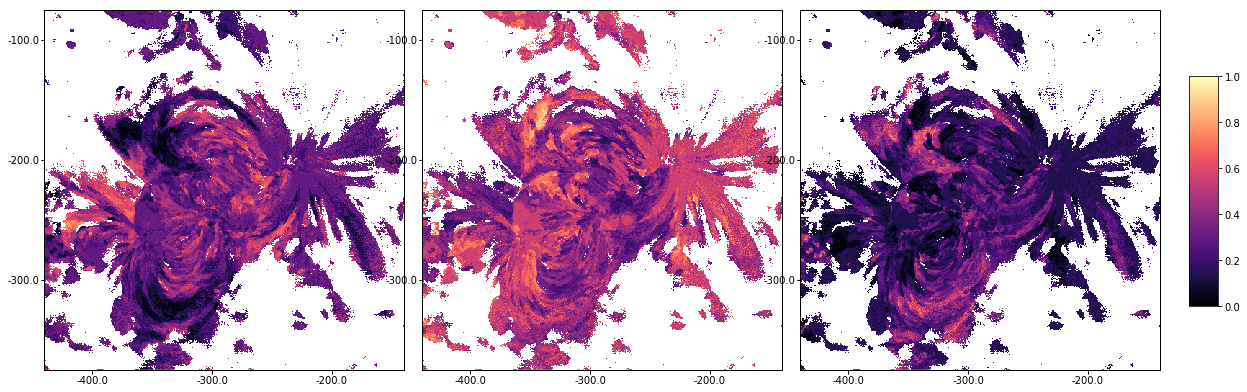

In [114]:
fig = plt.figure(figsize=(20,8))
cax = fig.add_axes((0.92,0.3,0.02,0.4))
p_args = {'annotate':False,'vmin':0,'vmax':1,'cmap':'magma'}
# Probability maps
## High
ax = fig.add_subplot(1,3,1,projection=probability_maps['High'])
probability_maps['High'].plot(axes=ax,**p_args,title='High')
ax.grid(alpha=0)
## Intermediate
ax = fig.add_subplot(1,3,2,projection=probability_maps['Intermediate'])
probability_maps['Intermediate'].plot(axes=ax,**p_args,title='Intermediate')
ax.grid(alpha=0)
## Low
ax = fig.add_subplot(1,3,3,projection=probability_maps['Low'])
im = probability_maps['Low'].plot(axes=ax,**p_args,title='Low')
ax.grid(alpha=0)
## Colorbar and adjustments
cbar = fig.colorbar(im, cax=cax,orientation='vertical')
plt.subplots_adjust(hspace=0,wspace=0.05)

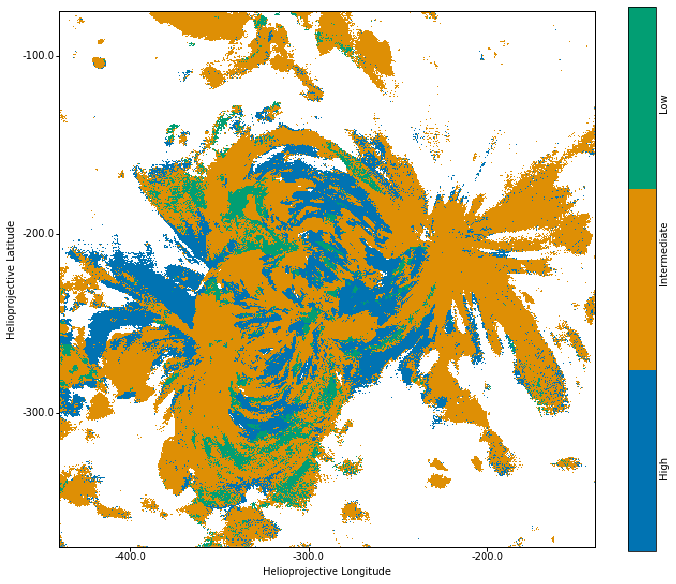

In [115]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=frequency_map)
im = frequency_map.plot(
    axes=ax,title=False,
    cmap=matplotlib.colors.ListedColormap(seaborn.color_palette(palette='colorblind',n_colors=3,),N=3),
    vmin=-0.5,vmax=2.5)
lon,lat = ax.coords[0],ax.coords[1]
lon.set_axislabel('Helioprojective Longitude',fontsize=plt.rcParams['axes.labelsize'])
lat.set_axislabel('Helioprojective Latitude',fontsize=plt.rcParams['axes.labelsize'])
lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'])
cbar = fig.colorbar(im, ax=ax,)# ticks=[0,1,2], format=plt.FuncFormatter(lambda val, loc: ['high','intermediate','low'][val]),)
cbar.set_ticks([0,1.3,2])
cbar.ax.set_yticklabels(['High','Intermediate','Low'],rotation=90)
cbar.ax.tick_params(axis='y',which='both',length=0)
ax.grid(alpha=0)

How do they differ?